# CloudSat in Python
### 課程開始前請各位同學執行：conda install -c conda-forge pyhdf
在這裡，我們會試著基於Python來處理CloudSat，另外有matlab code一樣可以處理CloudSat資料

以下會以2B-GEOPROF.hdf來當作示範的處理目標


In [ ]:
from pyhdf.SD  import SD, SDC
from pyhdf.VS import *
from pyhdf.V import *
from pyhdf.HDF import *
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
import numpy as np
import pprint
import gc 

#####Fuction for extracting variable names from hdf file
def HDFvars(File):
    hdfFile = SD(File, SDC.READ)
    dsets = hdfFile.datasets()
    k = []
    for key in dsets.keys():
        k.append(key)
    k.sort()
    hdfFile.end() # close the file
    return k
#####End 

In [8]:
### MODIS.hdf資料讀取###Demo 用
FILE_NAME ='MYD06_L2.A2009219.0525.061.2018045212424.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude_modis_north = lat[:,:]
lon = hdf.select('Longitude')
longitude_modis_north = lon[:,:]

# Read dataset.
top_temp = hdf.select('Cloud_Top_Temperature')
#pprint.pprint(top_temp.attributes())
for key, value in top_temp.attributes().items():
    print(key, value)
    if key == 'add_offset':
        add_offset = value  
    if key == 'scale_factor':
        scale_factor = value

top_temp_modis_north = (top_temp[:,:]-add_offset)*scale_factor
hdf.end() 
###

FILE_NAME = 'MYD06_L2.A2009219.0520.061.2018045212711.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude_modis_south = lat[:,:]
lon = hdf.select('Longitude')
longitude_modis_south = lon[:,:]

# Read dataset.
top_temp = hdf.select('Cloud_Top_Temperature')

top_temp_modis_south = (top_temp[:,:]-add_offset)*scale_factor
hdf.end() 
###

valid_range [0, 20000]
_FillValue -32768
long_name Temperature from Ancillary Data at Retrieved Cloud Top Pressure Level
units K
scale_factor 0.009999999776482582
add_offset -15000.0
Parameter_Type Output
Cell_Along_Swath_Sampling [3, 2028, 5]
Cell_Across_Swath_Sampling [3, 1348, 5]
Geolocation_Pointer Internal geolocation arrays


##Cloudsat.hdf資料讀取

In [10]:

filename = '2009219043145_17429_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf'
reading_vdata = HDF(filename, HC.READ).vstart()
vdata =reading_vdata.vdatainfo()
pprint.pprint(vdata[1:10])
members = [ 8 , 10, 11, 18 ,28 ,35] #資料的基本性質
nrecs = []
names = []
for ref in members:
 #       # Vdata tag
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  # number of records of the Vdata
    names.append(vd.inquire()[-1]) # name of the Vdata
    vd.detach()

print(names)
#print(nrecs)

#['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction','Navigation_land_sea_flag']
idx = names.index('UTC_start')
var = reading_vdata.attach(members[idx])
UTC_time = var.read(nrecs[idx])

idx = names.index('Latitude')
var = reading_vdata.attach(members[idx])
latitude = var.read(nrecs[idx])

idx = names.index('Longitude',)
var = reading_vdata.attach(members[idx])
longitude = var.read(nrecs[idx])

idx = names.index('MODIS_Cloud_Fraction',)
var = reading_vdata.attach(members[idx])
MODIS_cloud_fraction = var.read(nrecs[idx])

idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])

del reading_vdata
gc.collect()


[('UTC_start', '', 8, 1, 1, 5, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 5, 8, 1962, 0),
 ('Latitude', '', 10, 37080, 1, 5, 4, 1962, 0),
 ('Longitude', '', 11, 37080, 1, 5, 4, 1962, 0),
 ('Range_to_intercept', '', 13, 37080, 1, 5, 4, 1962, 0),
 ('DEM_elevation', '', 14, 37080, 1, 7, 2, 1962, 0),
 ('Vertical_binsize', '', 15, 1, 1, 5, 4, 1962, 0),
 ('Pitch_offset', '', 16, 1, 1, 5, 4, 1962, 0),
 ('Roll_offset', '', 17, 1, 1, 5, 4, 1962, 0)]
['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction', 'Navigation_land_sea_flag']


0

In [11]:
mo_longitude=np.asarray(longitude)
mo_latitude=np.asarray(latitude)
shape1 = mo_longitude.shape
lonlat_mask= np.zeros((shape1[0],1),dtype=int)

for i in range(0,shape1[0]):
    if mo_longitude[i] >115  and  mo_longitude[i]<125  and  mo_latitude[i] > 15  and  mo_latitude[i] < 30:
        lonlat_mask[i]= 1

taiwan_array_size=sum(lonlat_mask)
print("Array length over Taiwan area:")
print(sum(taiwan_array_size))


Array length over Taiwan area:
1556


In [12]:
HDFvars(filename)

['CPR_Cloud_mask', 'Gaseous_Attenuation', 'Height', 'Radar_Reflectivity']

In [13]:
hdfFile = SD(filename, SDC.READ)
Reflectivity = hdfFile.select('Radar_Reflectivity')
pprint.pprint(Reflectivity.attributes())
taiwan_Reflectivity= np.zeros((taiwan_array_size[0],125))
Height = hdfFile.select('Height')
taiwan_height= np.zeros((taiwan_array_size[0],125))
taiwan_lat= np.zeros((taiwan_array_size[0],1))
taiwan_lon= np.zeros((taiwan_array_size[0],1))
k=0
for i in range(0,shape1[0]):
    if lonlat_mask[i]>0:
        taiwan_Reflectivity[k,:]= Reflectivity[i,:]/100
        taiwan_height[k,:]=Height[i,:]
        taiwan_lat[k,0]=mo_latitude[i]
        taiwan_lon[k,0]=mo_longitude[i]
        k=k+1


{'_FillValue': 15360,
 'factor': 100.0,
 'long_name': 'Radar Reflectivity Factor',
 'missing': -8888,
 'missop': '==',
 'offset': 0.0,
 'units': 'dBZe',
 'valid_range': [-4000, 5000]}


In [14]:
Ref= taiwan_Reflectivity[:,:].T
r_Ref = Ref[::-1]
Hef= taiwan_height[:,:].T
r_Hef = Hef[::-1]
ref_height=np.mean(r_Hef,axis=1)
ref_height=np.around(ref_height)
taiwan_lat = np.around(taiwan_lat,decimals=1)

In [15]:
mo_longitude=np.asarray(longitude)

shape1 = mo_longitude.shape

for i in range(0,shape1[0]):
    if mo_longitude[i] < -60:
        mo_longitude[i]=mo_longitude[i]+360


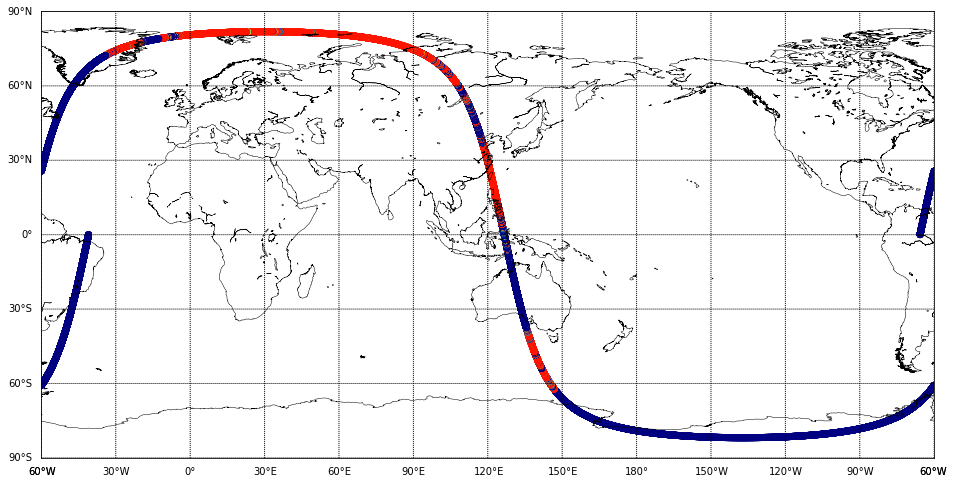

In [16]:
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=-60, urcrnrlon=300., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1])
m.scatter(mo_longitude[:], latitude[:] , c=MODIS_cloud_fraction[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)


如果我們把2009/8/7號當天所有CloudSat所觀測過的軌道畫出來

會長得如下圖所示:

<img src='img/demo_track.png'  />

先看看

2009/08/07當天台灣的MODIS衛星雲圖:

<img src='img/20090807.png'  />

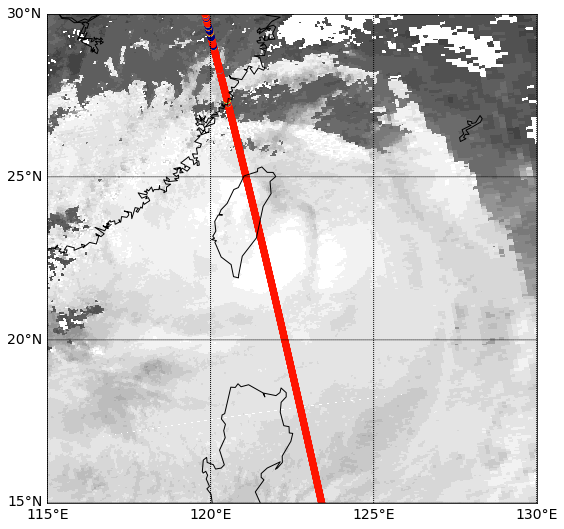

In [17]:
fig = plt.figure(figsize=(9,9)) 
m = Basemap(llcrnrlon=115, urcrnrlon=130., llcrnrlat=15., urcrnrlat=30.,resolution='l')
m.drawcoastlines(linewidth=1)
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0], fontsize=14)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1], fontsize=14)
x, y = m(longitude_modis_north, latitude_modis_north)
m.pcolormesh(x, y, top_temp_modis_north,cmap=plt.cm.get_cmap('gray_r',20), vmin=190, vmax=350)
x, y = m(longitude_modis_south, latitude_modis_south)
m.pcolormesh(x, y, top_temp_modis_south,cmap=plt.cm.get_cmap('gray_r',20), vmin=190, vmax=350)
m.scatter(mo_longitude[:], latitude[:] , c=MODIS_cloud_fraction[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)


Text(0.5, 0, 'Latitude')

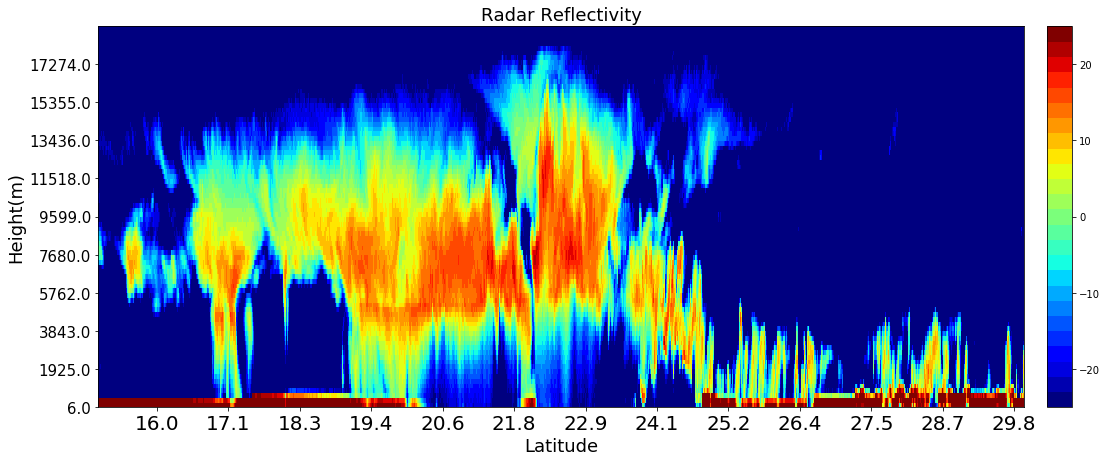

In [18]:
###雷達回波
fig = plt.figure(figsize=(20,7)) 
plt.pcolormesh(r_Ref[20:100,:],cmap=plt.cm.get_cmap('jet',25), vmin=-25, vmax=25)
plt.colorbar(aspect=15, pad=0.02)
plt.title('Radar Reflectivity',fontsize=18)
###XY軸設定指令
plt.yticks(np.arange(0,80,step=8), (ref_height[20:100:8,]))
plt.xticks(np.arange(99,1556,step=120), (taiwan_lat[99:1556:120,0]))
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=15)
plt.ylabel('Height(m)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

#Reference
####

In [19]:
demo_file = os.listdir('C:\\Users\\linnick\\Desktop\\cloudsat_python\\demo_track\\')
#print(demo_file)
srcdir  = 'C:\\Users\\linnick\\Desktop\\cloudsat_python\\demo_track\\'
demo_lon= np.zeros((37080,14))
demo_lat= np.zeros((37080,14))
demo_cloud_fraction= np.zeros((37080,14))
for i in range(0,14):
    filename_demo = [srcdir+demo_file[i]]
    #print(filename_demo)
    reading_vdata = HDF(filename_demo[0], HC.READ).vstart()
    vdata =reading_vdata.vdatainfo()
    #pprint.pprint(vdata[1:10])
    members = [ 8 , 10, 11, 18 ,28 ,35] #資料的基本性質
    nrecs = []
    names = []
    for ref in members:
 #       # Vdata tag
        vd = reading_vdata.attach(ref)
        nrecs.append(vd.inquire()[0])  # number of records of the Vdata
        names.append(vd.inquire()[-1]) # name of the Vdata
        vd.detach()

#print(names)
#print(nrecs)

#['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction','Navigation_land_sea_flag']

    idx = names.index('Latitude')
    var = reading_vdata.attach(members[idx])
    latitude_demo = var.read(nrecs[idx])

    latitude_demo=np.asarray(latitude_demo)
    demo_lat[:,i] = latitude_demo[0:37080,0]

    
    idx = names.index('Longitude',)
    var = reading_vdata.attach(members[idx])
    longitude_demo = var.read(nrecs[idx])
    longitude_demo=np.asarray(longitude_demo)
    demo_lon[:,i]=longitude_demo[0:37080,0]
    
    idx = names.index('MODIS_Cloud_Fraction',)
    var = reading_vdata.attach(members[idx])
    MODIS_cloud_fraction_demo = var.read(nrecs[idx])
    MODIS_cloud_fraction_demo =np.asarray(MODIS_cloud_fraction_demo )
    demo_cloud_fraction[:,i]=MODIS_cloud_fraction_demo[0:37080,0]
    del reading_vdata
    gc.collect()

In [37]:
shape1 = demo_lon.shape
print(shape1)

for i in range(0,37080):
    for j in range(0,14):
        if demo_lon[i,j] < -60:
            demo_lon[i,j]=demo_lon[i,j]+360
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=-60, urcrnrlon=300., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1])
for i in range(0,14):
    m.scatter(demo_lon[:,i], demo_lat[:,i] , c=demo_cloud_fraction[:,i] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)
fig.savefig('demo_track.png', dpi=250)

(37080, 14)
